<a href="https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF1_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GREMLIN_TF1_simple

This is a bare minimum version of GREMLIN (no gap removal, etc), intended for educational/demo purposes.

For the NEW version designed to integrate with TF2+Keras [see here](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb).

In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <koo@cshl.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

Select tensorflow version for Google Colab

In [0]:
%tensorflow_version 1.x

## Load some libraries

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import string

# importing functions specific to tensorflow v1
import tensorflow.compat.v1 as tf1

# disable eager execuation (if using tensorflow v2)
tf1.disable_eager_execution()

## Convert FASTA to MSA np.array()

In [0]:
def parse_fasta(filename, a3m=False):
  '''function to parse fasta file'''
  
  if a3m:
    # for a3m files the lowercase letters are removed
    # as these do not align to the query sequence
    rm_lc = str.maketrans(dict.fromkeys(string.ascii_lowercase))
    
  header, sequence = [],[]
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      if a3m: line = line.translate(rm_lc)
      else: line = line.upper()
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  
  return header, sequence
  
def mk_msa(seqs):
  '''one hot encode msa'''
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)  
  a2n = {a:n for n,a in enumerate(alphabet)}
  msa_ori = np.array([[a2n.get(aa, states-1) for aa in seq] for seq in seqs])
  return np.eye(states)[msa_ori]

## load example

In [0]:
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [6]:
names, seqs = parse_fasta("4FAZA.fas")
msa = mk_msa(seqs)

print(msa.shape)

(817, 62, 21)


### compute weight for each sequence
if your alignment has many redundant sequences, these should be downweighted!
For example, if two sequences share more 80% identity, they are effectively one sequence, and thus each would get a weight of 0.5.

In [0]:
from scipy.spatial.distance import pdist, squareform
def get_eff(msa, eff_cutoff=0.8):
  if msa.ndim == 3: msa = msa.argmax(-1)    
  # pairwise identity  
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))
  # weight for each sequence
  msa_w = (msa_sm >= eff_cutoff).astype(np.float)
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

In [0]:
msa_weights = get_eff(msa)

## GREMLIN
GREMLIN is technically an "autoencoder" with a single dense (or fully-connected) layer between the input and output, with no hidden variables. GREMLIN tries to minimize the difference between the input and output.  The "latent" variables are the (w)eights/(b)ias of the dense layer.

* loss = categorical_crossentropy(msa,  softmax(dot(msa, w) + b))
 - the math is identical to computing the "pseudolikelihood" as in GREMLIN()
 
* msa
 - msa.shape = (batch, L x 21)
 - 21 =  (20 amino acids + 1 gap) categories
* w = weight
 - w.shape = (L x 21, L x 21)
 -  aka two-body term of the MRF (aka co-evolution)
 -  note: the w matrix is symmetrized and the diagional is set to zero
* b = bias 
 - b.shape = (L x 21)
 - aka one-body-term of the MRF (aka conservation)

In [0]:
def GREMLIN_simple(msa, msa_weights=None, opt_iter=100):
  
  # collecting some information about input msa
  N = msa.shape[0] # number of sequences
  L = msa.shape[1] # length of sequence
  A = msa.shape[2] # number of states (or categories)
  
  # weights
  if msa_weights is None:
    msa_weights = np.ones(N)

  # kill any existing tensorflow graph
  tf1.reset_default_graph()

  # setting up weights
  b = tf1.get_variable("b", [L,A])
  w = tf1.get_variable("w", [L,A,L,A], initializer=tf.initializers.zeros)

  # symmetrize w
  w = w * np.reshape(1-np.eye(L),(L,1,L,1))
  w = w + tf.transpose(w,[2,3,0,1])
  
  # input
  MSA = tf.constant(msa,dtype=tf.float32)
  MSA_weights = tf.constant(msa_weights,dtype=tf.float32)

  # dense layer + softmax activation
  MSA_pred = tf.nn.softmax(tf.tensordot(MSA,w,2)+b,-1)

  # loss = categorical crossentropy (aka pseudo-likelihood)
  loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(MSA,MSA_pred),-1)
  loss = tf.reduce_sum(loss * MSA_weights)

  # add L2 regularization
  reg_b = 0.01 * tf.reduce_sum(tf.square(b))
  reg_w = 0.01 * tf.reduce_sum(tf.square(w)) * 0.5 * (L-1) * (A-1)
  loss = loss + reg_b + reg_w

  # setup optimizer
  learning_rate = 0.1 * np.log(N)/L
  opt = tf1.train.AdamOptimizer(learning_rate).minimize(loss)

  # optimize!
  with tf1.Session() as sess:
    sess.run(tf1.global_variables_initializer())

    # initialize bias
    pc = 0.01 * np.log(N)
    b_ini = np.log(np.sum(msa,0) + pc)
    b_ini = b_ini - np.mean(b_ini,-1,keepdims=True)
    sess.run(b.assign(b_ini))
    
    print("starting",sess.run(loss))

    for i in range(opt_iter):
      sess.run(opt)
      if (i+1) % int(opt_iter/10) == 0:
        print((i+1),sess.run(loss))

    # save the weights (aka V and W parameters of the MRF)
    V = sess.run(b)
    W = sess.run(w)
  return(V,W) 

In [14]:
%%time
V,W = GREMLIN_simple(msa, msa_weights)

starting 51558.387
10 30474.594
20 28137.197
30 27369.766
40 27132.457
50 27029.05
60 26978.797
70 26952.555
80 26937.062
90 26926.297
100 26917.89
CPU times: user 1.24 s, sys: 243 ms, total: 1.48 s
Wall time: 1.48 s


## get contacts

In [0]:
def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:-1,:,:-1]),(1,3)))

  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

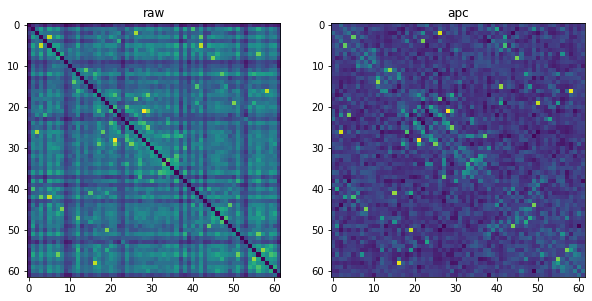

In [12]:
raw, apc = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()